In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install SpeechRecognition
!pip install googletrans==3.1.0a0
!pip install webrtcvad
!pip install scipy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 8.1 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=2c3f1f5f0ff5a12ffcf6061445c1664fffa7218a4e4df020997c782383576120
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling cha

In [ ]:
import speech_recognition as sr
from googletrans import Translator
from scipy.io import wavfile
import scipy
import webrtcvad

In [ ]:
# Start of model training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import pandas as pd
# import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# load the dataset
news_d = pd.read_csv("drive/MyDrive/covidSelfDataset.csv",encoding = "ISO-8859-1")
# news_d = news_d.astype({'label':'int'})
print(news_d.size)
# news_d = pd.read_csv("News.csv",encoding = "ISO-8859-1")
print("Shape of News data:", news_d.shape)
print("News data columns", news_d.columns)

# by using df.head(), we can immediately familiarize ourselves with the dataset.
print(news_d.head())

# Constants that are used to sanitize the datasets

# column_n = ['Date', 'Link', 'Text', 'Region', 'label']
# remove_c = ['Date','Link','Region']
column_n = ['Text', 'label']
# remove_c = []

# categorical_features = []
target_col = ['label']
text_f = ['Text']

49158
Shape of News data: (24579, 2)
News data columns Index(['Text', 'label'], dtype='object')
                                                Text  label
0  A post claims compulsory vacination violates t...      0
1  A photo claims that this person is a doctor wh...      0
2  Post about a video claims that it is a protest...      0
3  All deaths by respiratory failure and pneumoni...      0
4  The dean of the College of Biologists of Euska...      0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Clean Datasets
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from collections import Counter

ps = PorterStemmer()
wnl = nltk.stem.WordNetLemmatizer()

stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)

# Removed unused clumns
def remove_unused_c(df,column_n=remove_c):
    df = df.drop(column_n,axis=1)
    return df

# Impute null values with None
def null_process(feature_df):
    for col in text_f:
        feature_df.loc[feature_df[col].isnull(), col] = "None"
    return feature_df

def clean_dataset(df):
    # remove unused column
    df = remove_unused_c(df)
    #impute null values
    df = null_process(df)
    return df

# Cleaning text from unused characters
def clean_text(text):
    text = str(text).replace(r'http[\w:/\.]+', ' ')  # removing urls
    text = str(text).replace(r'[^\.\w\s]', ' ')  # remove everything but characters and punctuation
    text = str(text).replace('[^a-zA-Z]', ' ')
    text = str(text).replace(r'\s\s+', ' ') # white spaces more than one space convert to one space
    text = text.lower().strip()
    #text = ' '.join(text)
    return text

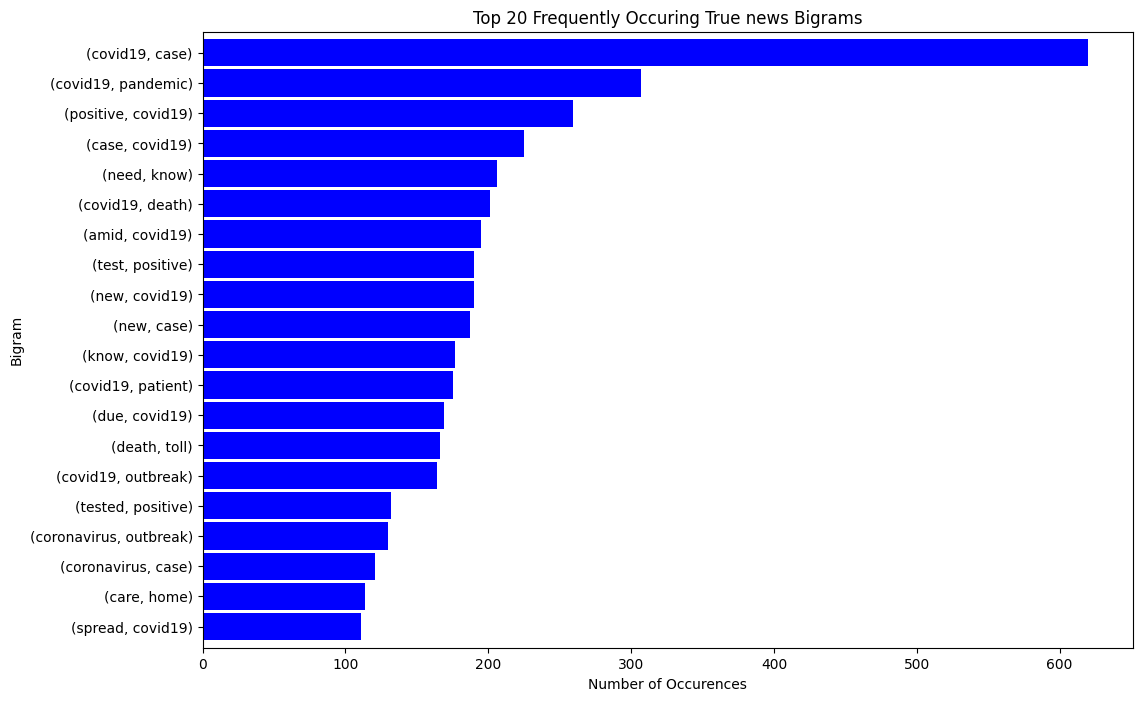

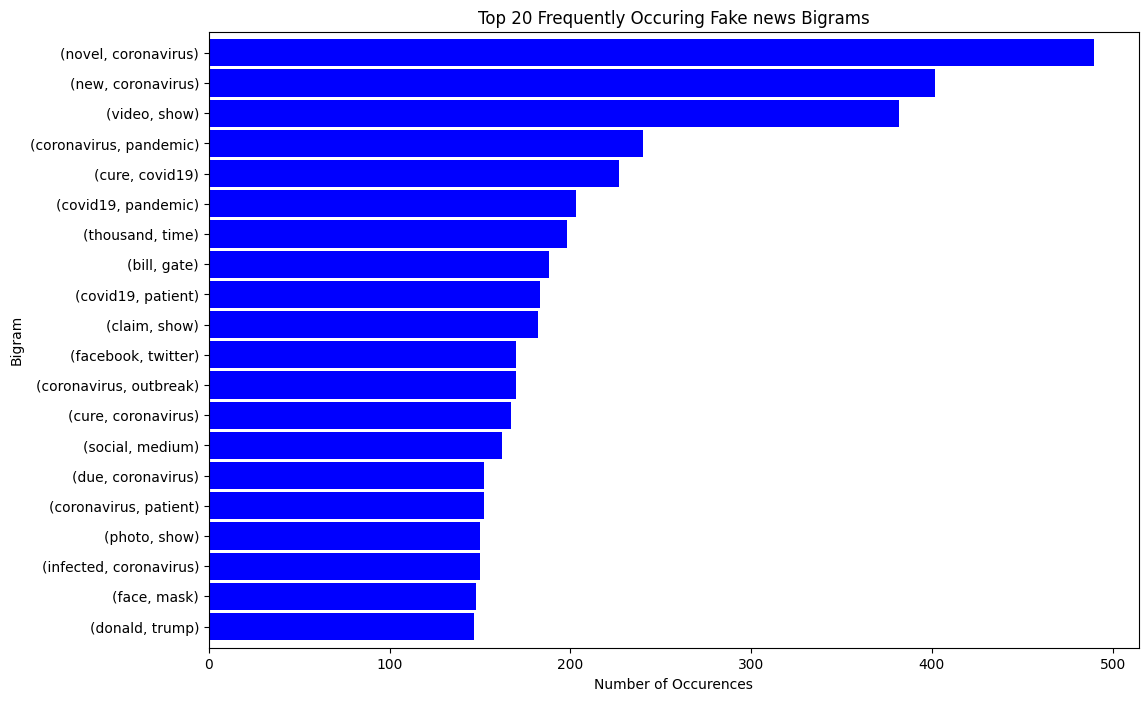

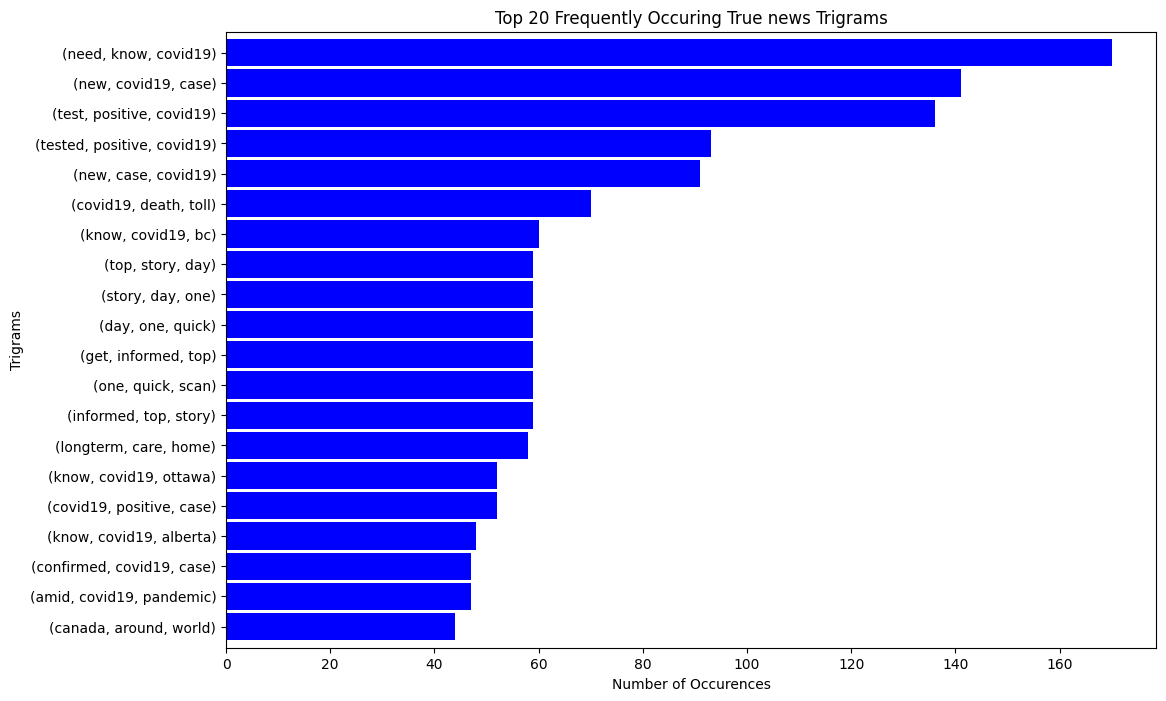

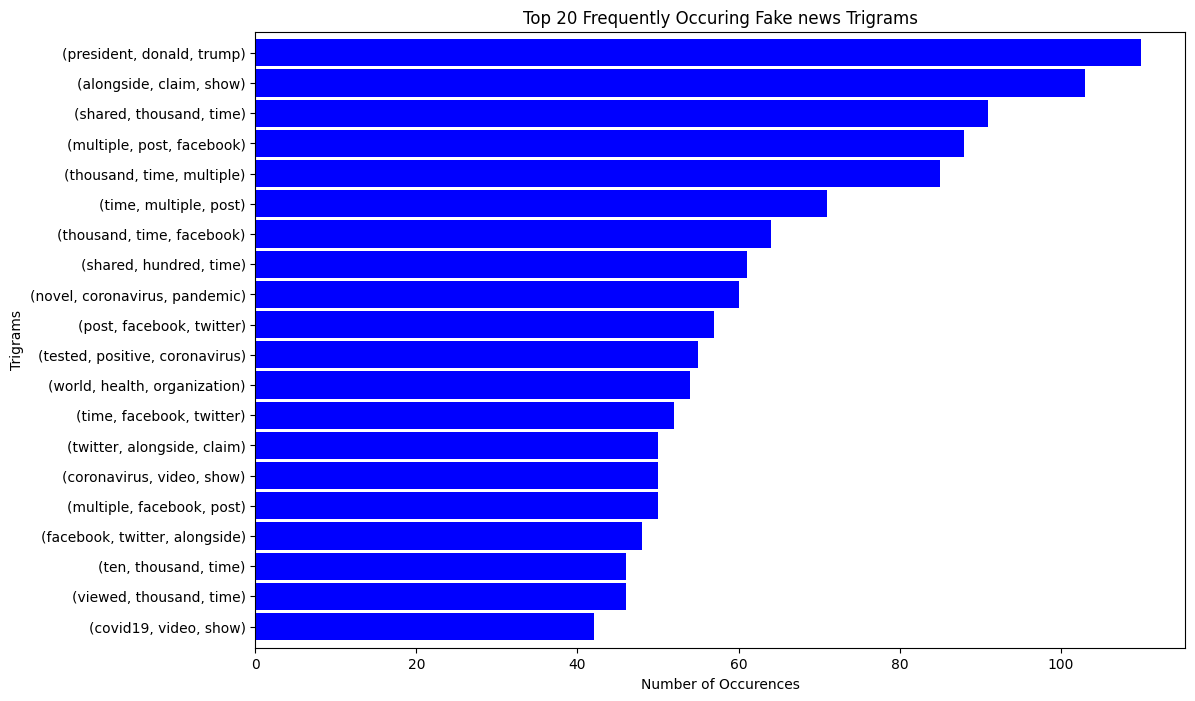

In [ ]:
## Nltk Preprocessing include:
# Stop words, Stemming and Lemmetization
# For our project we use only Stop word removal
def nltk_preprocess(text):
    text = clean_text(text)
    wordlist = re.sub(r'[^\w\s]', '', text).split()
    #text = ' '.join([word for word in wordlist if word not in stopwords_dict])
    #text = [ps.stem(word) for word in wordlist if not word in stopwords_dict]
    text = ' '.join([wnl.lemmatize(word) for word in wordlist if word not in stopwords_dict])
    return  text

# Perform data cleaning on train and test dataset by calling clean_dataset function
df = clean_dataset(news_d)
# apply preprocessing on text through apply method by calling the function nltk_preprocess
df["Text"] = df.Text.apply(nltk_preprocess)
# apply preprocessing on title through apply method by calling the function nltk_preprocess
# df["title"] = df.title.apply(nltk_preprocess)

fake_n = ' '.join(df[df['label']==0]['Text'])
true_n = ' '.join(df[df['label']==1]['Text'])

def plot_top_ngrams(corpus, title, ylabel, xlabel="Number of Occurences", n=2):
  """Utility function to plot top n-grams"""
  true_b = (pd.Series(nltk.ngrams(corpus.split(), n)).value_counts())[:20]
  true_b.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.show()

plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Bigrams', "Bigram", n=2)

plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Bigrams', "Bigram", n=2)

# Most frequent trigrams
plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Trigrams', "Trigrams", n=3)
plot_top_ngrams(fake_n, 'Top 20 Frequently Occuring Fake news Trigrams', "Trigrams", n=3)

In [ ]:
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.6 MB/s eta 0:00:00


In [ ]:
# plot_top_ngrams(true_n, 'Top 20 Frequently Occuring True news Bigrams', "Bigram", n=2)

import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.model_selection import train_test_split

import random

def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

set_seed(1)


In [ ]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

news_df = news_d[news_d['Text'].notna()]
# news_df = news_df[news_df["author"].notna()]
# news_df = news_df[news_df["title"].notna()]

def prepare_data(df, test_size=0.2, include_title=True, include_author=True):
  texts = []
  labels = []
  for i in range(len(df)):
    text = df["Text"].iloc[i]
    label = df["label"].iloc[i]
    # if include_title:
    #   text = df["title"].iloc[i] + " - " + text
    # if include_author:
    #   text = df["author"].iloc[i] + " : " + text
    if text and label in [0, 1]:
      texts.append(text)
      labels.append(label)
  return train_test_split(texts, labels, test_size=test_size)

train_texts, valid_texts, train_labels, valid_labels = prepare_data(news_df)

print(len(train_texts), len(train_labels))
print(len(valid_texts), len(valid_labels))

# tokenize the dataset, truncate when passed `max_length`,
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)

class NewsGroupsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = NewsGroupsDataset(train_encodings, train_labels)
valid_dataset = NewsGroupsDataset(valid_encodings, valid_labels)

# load the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

from sklearn.metrics import accuracy_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    warmup_steps=100,                # number of warmup steps for learning rate scheduler
    logging_dir='./logs',            # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    # but you can specify `metric_for_best_model` argument to change to accuracy or other metric
    logging_steps=200,               # log & save weights each logging_steps
    save_steps=200,
    evaluation_strategy="steps",     # evaluate each `logging_steps`
)


trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=valid_dataset,          # evaluation dataset
    compute_metrics=compute_metrics,     # the callback that computes metrics of interest
)

# train the model
trainer.train()

# evaluate the current model after training
trainer.evaluate()

# saving the fine tuned model & tokenizer
model_path = "drive/MyDrive/colabfolder/fake-news-bert-base-uncased"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

19663 19663
4916 4916


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
200,0.274400,0.106438,0.970708
400,0.117100,0.075594,0.979658
600,0.144300,0.115145,0.970301
800,0.104700,0.075486,0.982303
1000,0.102300,0.056498,0.983930
1200,0.078000,0.060651,0.984133
1400,0.081200,0.060668,0.983116
1600,0.068100,0.059126,0.985557
1800,0.041300,0.058061,0.986574


('drive/MyDrive/colabfolder/fake-news-bert-base-uncased/tokenizer_config.json',
 'drive/MyDrive/colabfolder/fake-news-bert-base-uncased/special_tokens_map.json',
 'drive/MyDrive/colabfolder/fake-news-bert-base-uncased/vocab.txt',
 'drive/MyDrive/colabfolder/fake-news-bert-base-uncased/added_tokens.json',
 'drive/MyDrive/colabfolder/fake-news-bert-base-uncased/tokenizer.json')

In [ ]:
# Getting text from audio
def transcribe_audio(audio_path, lang):
    translator=Translator()
    if lang == 'Sinhala':
        # Convert audio to text using Google Cloud Speech API
        r = sr.Recognizer()
        with sr.AudioFile(audio_path) as source:
            audio = r.record(source)
        text = r.recognize_google(audio, language='si-LK')
        print(text)
        # translator = translate.Translator()
        result = translator.translate(text)
        text = result.text
        print(text)
        # Print the transcribed text
        print("Transcribed Text: ", text)

    elif lang == 'Tamil':
        # Convert audio to text using Google Cloud Speech API
        r = sr.Recognizer()
        with sr.AudioFile(audio_path) as source:
            audio = r.record(source)
        text = r.recognize_google(audio, language='ta-LK')
        print(text)
        # translator = translate.Translator()
        result = translator.translate(text)
        text = result.text
        print(text)
        # Print the transcribed text
        print("Transcribed Text: ", text)

    else:
        # Convert audio to text using Google Cloud Speech API
        r = sr.Recognizer()
        with sr.AudioFile(audio_path) as source:
            audio = r.record(source)
        text = r.recognize_google(audio)

        # Print the transcribed text
        print("Transcribed Text: ", text)

    return text


def is_human_audio(audio_path):
  fs, audio = wavfile.read(audio_path)
  audio_n = audio/float(2**15)

  vad = webrtcvad.Vad(3)
  def audioSlice(x, fs, framesz, hop):
      framesamp = int(framesz*fs)
      hopsamp = int(hop*fs)
      X = scipy.array([x[i:i+framesamp] for i in range(0, len(x)-framesamp, hopsamp)])
      return X
  framesz=10./1000 #10 ms
  hop = 1.0*framesz
  Z = audioSlice(audio_n, fs, framesz, hop)
  fr = np.int16(Z[100] * 32768).tobytes()
  aud = vad.is_speech(fr, fs)
  if (aud):
      print("Human Voice ")
      return True
  else:
      print("Generated Voice")
      return False

In [ ]:
model_name2 = "drive/MyDrive/colabfolder/fake-news-bert-base-uncased"

# load the tokenizer
tokenizer2 = BertTokenizerFast.from_pretrained(model_name2, do_lower_case=True)
# load the model
model2 = BertForSequenceClassification.from_pretrained(model_name2, num_labels=2)

def get_prediction(text, convert_to_label=False):
    # prepare our text into tokenized sequence
    inputs = tokenizer2(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to our model
    outputs = model2(**inputs)
    # get output probabilities by doing softmax
    probs = outputs[0].softmax(1)
    print(probs)
    # executing argmax function to get the candidate label
    d = {
        1: "reliable",
        0: "fake"
    }
    if convert_to_label:
      return d[int(probs.argmax())]
    else:
      return int(probs.argmax())

# news = 'do not inject vaccine. it is not good for health'

# get_prediction(news, convert_to_label=True)

In [ ]:
if __name__ == "__main__":

   # Transcribe the audio to text
    lang = input("Is This English or Sinhala or Tamil.?")

    if lang=='Sinhala':
      audio_path = "/content/Sinhala voice.wav"
    elif lang=='Tamil':
      audio_path = "/content/Tamil voice.wav"
    else:
      audio_path = "/content/English voice.wav"
    text_news = transcribe_audio(audio_path,lang)
    #print(audio_path)
    # Detect if the audio is human or generated
    is_human = is_human_audio(audio_path)


    print(f"Input Text: {text_news}")

    pred_result = get_prediction(text_news, convert_to_label=True)
    if pred_result == 'reliable':
      print('News is Real')
    else:
      print('News is a fake')

Is This English or Sinhala or Tamil.?Tamil
கொரோனா வைரஸ் முதன் முதலில் முகாம் நகரில் கண்டறியப்பட்டது
The coronavirus was first detected in Camp Nagar
Transcribed Text:  The coronavirus was first detected in Camp Nagar
Generated Voice
Input Text: The coronavirus was first detected in Camp Nagar
tensor([[0.0039, 0.9961]], grad_fn=<SoftmaxBackward0>)
News is Real


<ipython-input-23-10fb6f7874a6>:53: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  X = scipy.array([x[i:i+framesamp] for i in range(0, len(x)-framesamp, hopsamp)])
